# Zerocrossing_rate_resNet50

In [1]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras import optimizers, losses, activations, models
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [2]:
train_path= 'C:/Users/ASUS/Desktop/zero_res/train'
test_path= 'C:/Users/ASUS/Desktop/zero_res/test'
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)

In [3]:
print(class_names)
print(class_names_test)

['abnormal', 'normal']
['abnormal', 'normal']


In [4]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()

In [5]:
train_generator = train_datagen.flow_from_directory('C:/Users/ASUS/Desktop/zero_res/train',target_size=(224, 224),batch_size=32,shuffle=True,class_mode='binary')
test_generator = test_datagen.flow_from_directory('C:/Users/ASUS/Desktop/zero_res/test',target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')

Found 495 images belonging to 2 classes.
Found 211 images belonging to 2 classes.


In [6]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [7]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [8]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [9]:
base_model = ResNet50(input_shape=(224, 224, 3))

In [10]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [11]:
model = Model(inputs=base_model.input, outputs=headModel)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

                                                                                                  
 activation_8 (Activation)      (None, 55, 55, 64)   0           ['bn2c_branch2b[0][0]']          
                                                                                                  
 res2c_branch2c (Conv2D)        (None, 55, 55, 256)  16640       ['activation_8[0][0]']           
                                                                                                  
 bn2c_branch2c (BatchNormalizat  (None, 55, 55, 256)  1024       ['res2c_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_2 (Add)                    (None, 55, 55, 256)  0           ['bn2c_branch2c[0][0]',          
                                                                  'activation_6[0][0]']           
          

 ion)                                                                                             
                                                                                                  
 add_5 (Add)                    (None, 28, 28, 512)  0           ['bn3c_branch2c[0][0]',          
                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 28, 28, 512)  0           ['add_5[0][0]']                  
                                                                                                  
 res3d_branch2a (Conv2D)        (None, 28, 28, 128)  65664       ['activation_18[0][0]']          
                                                                                                  
 bn3d_branch2a (BatchNormalizat  (None, 28, 28, 128)  512        ['res3d_branch2a[0][0]']         
 ion)     

 add_8 (Add)                    (None, 14, 14, 1024  0           ['bn4b_branch2c[0][0]',          
                                )                                 'activation_24[0][0]']          
                                                                                                  
 activation_27 (Activation)     (None, 14, 14, 1024  0           ['add_8[0][0]']                  
                                )                                                                 
                                                                                                  
 res4c_branch2a (Conv2D)        (None, 14, 14, 256)  262400      ['activation_27[0][0]']          
                                                                                                  
 bn4c_branch2a (BatchNormalizat  (None, 14, 14, 256)  1024       ['res4c_branch2a[0][0]']         
 ion)                                                                                             
          

                                                                                                  
 res4f_branch2a (Conv2D)        (None, 14, 14, 256)  262400      ['activation_36[0][0]']          
                                                                                                  
 bn4f_branch2a (BatchNormalizat  (None, 14, 14, 256)  1024       ['res4f_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_37 (Activation)     (None, 14, 14, 256)  0           ['bn4f_branch2a[0][0]']          
                                                                                                  
 res4f_branch2b (Conv2D)        (None, 14, 14, 256)  590080      ['activation_37[0][0]']          
                                                                                                  
 bn4f_bran

 ion)                                                                                             
                                                                                                  
 activation_46 (Activation)     (None, 7, 7, 512)    0           ['bn5c_branch2a[0][0]']          
                                                                                                  
 res5c_branch2b (Conv2D)        (None, 7, 7, 512)    2359808     ['activation_46[0][0]']          
                                                                                                  
 bn5c_branch2b (BatchNormalizat  (None, 7, 7, 512)   2048        ['res5c_branch2b[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_47 (Activation)     (None, 7, 7, 512)    0           ['bn5c_branch2b[0][0]']          
          

In [13]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# weight_path="{}_weights.best.hdf5".format('spectro_sound_model')
checkpoint = ModelCheckpoint(filepath ="./check.hDf5", monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
# reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', 
#                                    factor=0.8, patience=5, 
#                                    verbose=1, mode='auto', 
#                                    epsilon=0.0001, cooldown=5, 
#                                    min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early]

In [14]:
import tensorflow as tf
from keras.models import *
from keras.layers import *
opt = tf.optimizers.Adam(lr=1e-3)
model.compile(optimizer=opt, 
    loss=losses.binary_crossentropy, 
    metrics=['accuracy', 'Precision', 'AUC', tf.keras.metrics.Recall(), tf.keras.metrics.TrueNegatives()])

C:\Users\ASUS\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
training_images = 456
validation_images = 144 

history = model.fit_generator(train_generator, # this should be equal to total number of images in training set. But to speed up the execution, I am only using 10000 images. Change this for better results. 
                   epochs = 50,  # change this for better results
                   validation_data = test_generator)  # this should be equal to total number of images in validation set.

C:\Users\ASUS\AppData\Local\Temp/ipykernel_5552/615836474.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, # this should be equal to total number of images in training set. But to speed up the execution, I am only using 10000 images. Change this for better results.


Epoch 1/50
16/16 [==============================] - 200s 12s/step - loss: 8.1728 - accuracy: 0.5111 - precision: 0.5391 - auc: 0.4830 - recall: 0.4769 - true_negatives: 129.0000 - val_loss: 75942.7500 - val_accuracy: 0.5261 - val_precision: 0.5261 - val_auc: 0.5000 - val_recall: 1.0000 - val_true_negatives: 0.0000e+00
Epoch 2/50
16/16 [==============================] - 178s 11s/step - loss: 2.1375 - accuracy: 0.5091 - precision: 0.5265 - auc: 0.5082 - recall: 0.6500 - true_negatives: 83.0000 - val_loss: 299.7792 - val_accuracy: 0.5261 - val_precision: 0.5261 - val_auc: 0.5000 - val_recall: 1.0000 - val_true_negatives: 0.0000e+00
Epoch 3/50
16/16 [==============================] - 175s 11s/step - loss: 0.9783 - accuracy: 0.5253 - precision: 0.5498 - auc: 0.5264 - recall: 0.5308 - true_negatives: 122.0000 - val_loss: 35149.6875 - val_accuracy: 0.4739 - val_precision: 0.0000e+00 - val_auc: 0.5000 - val_recall: 0.0000e+00 - val_true_negatives: 100.0000
Epoch 4/50
16/16 [===================

Epoch 27/50
16/16 [==============================] - 176s 11s/step - loss: 0.6307 - accuracy: 0.6242 - precision: 0.6779 - auc: 0.6946 - recall: 0.5423 - true_negatives: 168.0000 - val_loss: 0.7364 - val_accuracy: 0.4597 - val_precision: 0.4908 - val_auc: 0.4206 - val_recall: 0.7207 - val_true_negatives: 17.0000
Epoch 28/50
16/16 [==============================] - 175s 11s/step - loss: 0.6470 - accuracy: 0.5818 - precision: 0.5831 - auc: 0.6559 - recall: 0.7154 - true_negatives: 102.0000 - val_loss: 0.7081 - val_accuracy: 0.4597 - val_precision: 0.4400 - val_auc: 0.6119 - val_recall: 0.0991 - val_true_negatives: 86.0000
Epoch 29/50
16/16 [==============================] - 176s 11s/step - loss: 0.6608 - accuracy: 0.5859 - precision: 0.6244 - auc: 0.6352 - recall: 0.5308 - true_negatives: 152.0000 - val_loss: 0.7312 - val_accuracy: 0.5261 - val_precision: 0.5301 - val_auc: 0.5118 - val_recall: 0.8739 - val_true_negatives: 14.0000
Epoch 30/50
16/16 [==============================] - 175s 

In [16]:
import statistics
print (statistics.mean(history.history['accuracy']))
print (statistics.mean(history.history['val_accuracy']))

0.6110303056240082
0.4800000023841858


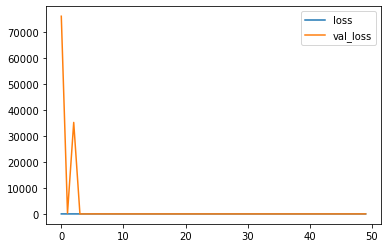

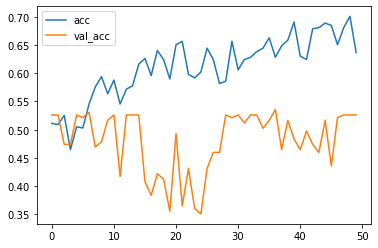

In [17]:
#Some visualizations
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [18]:
model.evaluate(test_generator)

7/7 [==============================] - 15s 2s/step - loss: 2.2340 - accuracy: 0.5261 - precision: 0.5261 - auc: 0.3973 - recall: 1.0000 - true_negatives: 0.0000e+00    


[2.2339584827423096,
 0.5260663628578186,
 0.5260663628578186,
 0.39725223183631897,
 1.0,
 0.0]